In [1]:
from sklearn.model_selection import train_test_split
import unittest
import numpy as np
from keras_performer import performer as tfr
import nltk

from os import listdir
from os.path import isfile, isdir, join
from nltk.tokenize import wordpunct_tokenize

nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
import tensorflow as tf
import glob

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\W.R_Chen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
'''
def solve_cudnn_error():
    import tensorflow as tf
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)
            
solve_cudnn_error()
'''

'\ndef solve_cudnn_error():\n    import tensorflow as tf\n    gpus = tf.config.experimental.list_physical_devices(\'GPU\')\n    if gpus:\n        try:\n            # Currently, memory growth needs to be the same across GPUs\n            for gpu in gpus:\n                tf.config.experimental.set_memory_growth(gpu, True)\n            logical_gpus = tf.config.experimental.list_logical_devices(\'GPU\')\n            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")\n        except RuntimeError as e:\n            # Memory growth must be set before GPUs have been initialized\n            print(e)\n            \nsolve_cudnn_error()\n'

In [3]:
import csv
def readCSV(file_name):
    errlist=[]
    LBlist=[]
    with open(file_name, newline='') as csvfile:
    #讀取 CSV 檔內容，將每一列轉成一個 dictionary

        rows = csv.DictReader(csvfile)
        for row in rows: 
            RL=list(row.values())
            #print("RL[0]: ", type(RL[0]), "RL[1]: ", type(RL[1]))
            RL[1:] = list(map(int, RL[1:]))
            errs=RL[1:37]
            LB=RL[37:]
            errlist.append(errs)
            LBlist.append(LB)
    return errlist,LBlist


In [4]:
def find_first_sublist(seq, sublist, start=0):
    length = len(sublist)
    for index in range(start, len(seq)):
        if seq[index:index+length] == sublist:
            return index, index+length

In [5]:
def replace_sublist(seq, sublist, replacement):
    length = len(replacement)
    index = 0
    for start, end in iter(lambda: find_first_sublist(seq, sublist, index), None):
        seq[start:end] = replacement
        index = start + length

In [6]:
def replaceTAGS(x):
    replace_sublist(x, ['<', 'NUM_INT', '>'], ["<NUM_INT>"])
    replace_sublist(x, ['<', 'NUM_FLOAT', '>'], ["<NUM_FLOAT>"])
    replace_sublist(x, ['<', 'STRING', '>'], ["<STRING>"])
    replace_sublist(x, ['<', 'BOC', '>'], ["<BOC>"])
    replace_sublist(x, ['<', 'EOC', '>'], ["<EOC>"])
    replace_sublist(x, ['<', 'BOTM', '>'], ["<BOTM>"])
    replace_sublist(x, ['<', 'BOT', '>'], ["<BOT>"])
    replace_sublist(x, ['<', 'EOT', '>'], ["<EOT>"])
    replace_sublist(x, ['<', 'BOM', '>'], ["<BOM>"])
    replace_sublist(x, ['<', 'EOM', '>'], ["<EOM>"])
    replace_sublist(x, ['<', 'EOTM', '>'], ["<EOTM>"])
    replace_sublist(x, ['<', 'CR', '>'], ["<CR>"])
    return x

In [7]:
def parseSentence(x):	
    tokenizer = RegexpTokenizer(r"[\w']+|[].,:!?;=+-\\*/@#$%^&_(){}~|\"[]")
    tokens=[]
    state="START"
    chrs=""
    for i in range(len(x)):
        #print(ord(x[i]))
        if (ord(x[i])>255):
            inp="U"
        else:
            inp="E"

        if state=="START":
            if inp=="E":
                state="ASCII"
                chrs=x[i]
            else:
                state="UNICODE"
                tokens.append(x[i])

        elif state=="ASCII":
            if inp=="E":
                chrs += x[i]
            else:#U
                state="UNICODE"
                tokens += tokenizer.tokenize(chrs) #wordpunct_tokenize(chrs)  #nltk.word_tokenize(chrs)
                chrs=""
                tokens.append(x[i])

        elif state=="UNICODE":
            if inp=="E":
                state="ASCII"
                chrs=x[i]
            else:
                state="UNICODE"
                tokens.append(x[i])
    if len(chrs)>0:
        tokens += tokenizer.tokenize(chrs) #wordpunct_tokenize(chrs)  # nltk.word_tokenize(chrs) 
    return tokens

In [8]:
def readcode(fname):
    with open(fname,encoding = 'utf-8') as f:
        data = f.read()
        return data

In [35]:
from matplotlib import pyplot as plt
#draw model total losses
def plotTrainingLoss(history):
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

In [36]:
#draw output2 acc
def plotTrainingErrorLineAcc(history):
    #======================accuracy======================
    acc = []
    #get all sample name
    names = []
    for sample in range(360):
        #get NN name
        name = "LNout" + str(sample) + "_categorical_accuracy"
        names.append(name)
    #get each epoch avg value
    for epoch in range(len(history[names[0]])): #get sample length
        one_epoch_sum = 0.0
        #print("epoch loop: ", epoch)
        for name in (names):
            one_epoch_sum += history[name][epoch]
        one_epoch_avg = one_epoch_sum / len(names) #get one epoch avg
        acc.append(one_epoch_avg) #return to acc
    plt.plot(acc)
    
    #======================validation accuary======================
    val_acc = []
    #get all sample name
    val_names = []
    for val_sample in range(360):
        #get NN name
        val_name = "val_LNout" + str(val_sample) +"_categorical_accuracy"
        val_names.append(val_name)
        
    #get each epoch avg value
    for epoch in range(len(history[names[0]])): #get sample length
        val_one_epoch_sum = 0.0
        for name in (val_names):
            val_one_epoch_sum += history[name][epoch]
        val_one_epoch_avg = val_one_epoch_sum / len(val_names) #get one epoch avg
        val_acc.append(val_one_epoch_avg) #return to acc
    plt.plot(val_acc)
    
    plt.ylabel('output2_acc')
    plt.xlabel('epoch')
    plt.show()

In [37]:
#draw output2 loss
def plotTrainingErrorLineLoss(history):
    #======================accuracy======================
    acc = []
    #get all sample name
    names = []
    for sample in range(360):
        #get NN name
        name = "LNout" + str(sample) + "_loss"
        names.append(name)
    #get each epoch avg value
    for epoch in range(len(history[names[0]])): #get sample length
        one_epoch_sum = 0.0
        #print("epoch loop: ", epoch)
        for name in (names):
            one_epoch_sum += history[name][epoch]
        one_epoch_avg = one_epoch_sum / len(names) #get one epoch avg
        acc.append(one_epoch_avg) #return to acc
    plt.plot(acc)
    
    #======================validation accuary======================
    val_acc = []
    #get all sample name
    val_names = []
    for val_sample in range(360):
        #get NN name
        val_name = "val_LNout" + str(val_sample) +"_loss"
        val_names.append(val_name)
        
    #get each epoch avg value
    for epoch in range(len(history[names[0]])): #get sample length
        val_one_epoch_sum = 0.0
        for name in (val_names):
            val_one_epoch_sum += history[name][epoch]
        val_one_epoch_avg = val_one_epoch_sum / len(val_names) #get one epoch avg
        val_acc.append(val_one_epoch_avg) #return to acc
    plt.plot(val_acc)
    
    plt.ylabel('output2_loss')
    plt.xlabel('epoch')
    plt.show()

In [38]:
#draw output1 binary acc
def plotTrainingErrorTypeAcc(history):
    plt.plot(history['error_feed_forward_output1_binary_accuracy']) 
    plt.plot(history['val_error_feed_forward_output1_binary_accuracy'])
    plt.title('model error_feed_forward_output1_binary_accuracy')
    plt.ylabel('error_feed_forward_output1_binary_accuracy')
    plt.xlabel('epoch')
    plt.show()

In [39]:
#draw output1 binary loss
def plotTrainingErrorTypeLoss(history):
    plt.plot(history['error_feed_forward_output1_loss']) 
    plt.plot(history['val_error_feed_forward_output1_loss'])
    plt.title('model error_feed_forward_output1_loss')
    plt.ylabel('error_feed_forward_output1_loss')
    plt.xlabel('epoch')
    plt.show()

In [12]:
import os
def listdir_fullpath(d):
    return [f for f in os.listdir(d)]

In [13]:
#save model for training
class TestTranslate(unittest.TestCase):
        
    def __init__(self):
        self.source_token_dict = {
            '<PAD>': 0,
            '<START>': 1,
            '<END>': 2,
            '<BOC>': 3,
            '<EOC>': 4,
            '<CR>': 5,
            '<NUM_INT>': 6,
            '<NUM_FLOAT>': 7,
            '<STRING>': 8,
        }
        
    @staticmethod
    def _build_token_dict(token_dict, token_list):
        for tokens in token_list:
            for token in tokens:
                if token not in token_dict:
                    token_dict[token] = len(token_dict)
        return token_dict
    
    def test_translate(self):
        #print("i am here: " )
        #source_file=[]
        #Set Para
        max_javaline_length = 160 #Max number of lines
        #set path
        Output_Path = "Trianing\InputCSV\Split-500-reduce-binary-accuracy"
        Input_Path = "Trianing\InputTxt\Split-500-reduce-binary-accuracy"
        model_for_training_org_path = "Model-for-training-org\Split-500-reduce-binary-accuracy"
        model_for_training_path = "Model-for-training\Split-500-reduce-binary-accuracy"
        Trained_model_Path = "Trained_models\Split-500-reduce-binary-accuracy\Learning-rate-4x0\weight-1vs2"
        #get all txt file in input path
        in_path = (glob.glob(Input_Path + "/**/*.txt"))
        #print("in_path: ", in_path)
        #cases = listdir_fullpath(Input_Path)
        source_max_len = 0
        target_max_len = 0
        token_num = 0
        all_sample_num = 16644 #all sample number
        block_num = 16644 #sample num e.g 10000 sample have 10*1000
        #Set model para
        training_source_max_len = 300 #for replace source_max_len
        self.sl = 0
        
        import math
        for loop in range(0, math.ceil(all_sample_num/block_num)): #new version 
        #for loop in range(0, round(336/block_num)): #old version
            print("First loop: ", loop)
            source_tokens = []
            target_errors = []
            target_LB = []
            if(all_sample_num % block_num == 0):
                dirs = block_num
            else:
                dirs = block_num if loop < all_sample_num // block_num else all_sample_num % block_num
            Input_fullpath = []
            Output_fullpath = []
            #print("dirs: ", dirs)
            for i in range(dirs):
                Input_fullpath.append(in_path[loop*block_num + i])                    
            for f in Input_fullpath:
                if isfile(f):
                    source_tokens.append(parseSentence(readcode(f)))
                    #print("source_tokens length: ", len(source_tokens))
                #if len(source_tokens)>max_files: break
            #get csv file     
            out_path = Output_Path + "/" + "test" + str(loop)+".csv"
            Output_fullpath = glob.glob(out_path)
            
            for f in Output_fullpath:
                if isfile(f):
                    err,lb = readCSV(f)
                    target_errors.append(err)
                    target_LB.append(lb)
                #if len(source_tokens)>max_files: break
            dd = np.asarray(target_errors)
            target_errors = target_errors[0]  
            target_LB = target_LB[0]     
            
            #change source token length
            source_tokens2 = []
            target_errors2 = []
            target_LB2 = []

            THRESHOLD_FILE_LEN = training_source_max_len
            for i in range(len(source_tokens)):
                src = source_tokens[i]
                target_error = target_errors[i]
                target_LBs = target_LB[i]
                if (len(src)<=THRESHOLD_FILE_LEN):# and  len(target)<=THRESHOLD_FILE_LEN):
                    source_tokens2.append(src)
                    target_errors2.append(target_error)
                    target_LB2.append(target_LBs)
            source_tokens = source_tokens2
            target_errors = target_errors2 #list of intgers, error types
            target_LB = target_LB2
            
            # Generate dictionaries
            self._build_token_dict(self.source_token_dict, source_tokens)
            
            # Add special tokens
            encode_tokens = [['<START>'] + tokens + ['<END>'] for tokens in source_tokens]
            
            #output_tokens = [tokens + ['<END>', '<PAD>'] for tokens in target_tokens] 
            
            self.sl = max(list(map(len, encode_tokens))+[self.sl])
            source_max_len = self.sl

        #padding here
        print("source_max_len:", source_max_len)
        for loop in range(0, math.ceil(all_sample_num/block_num)): #new version
        #for loop in range(0, round(336/block_num)): #old version
            print("Second loop: ", loop)
            source_tokens = []
            target_errors = []
            target_LB = []
            if(all_sample_num % block_num == 0):
                dirs = block_num
            else:
                dirs = block_num if loop < all_sample_num // block_num else all_sample_num % block_num
            Input_fullpath = []
            Output_fullpath = []
            for i in range(dirs):
                Input_fullpath.append(in_path[loop*block_num + i])
            for f in Input_fullpath:
                if isfile(f):
                    source_tokens.append(parseSentence(readcode(f)))

            out_path = Output_Path + "/" + "test"+ str(loop)+ ".csv"
            Output_fullpath = glob.glob(out_path)
            for f in Output_fullpath:
                if isfile(f):
                    err, lb = readCSV(f)
                    target_errors.append(err)
                    target_LB.append(lb)
            #if len(source_tokens)>max_files: break
            dd = np.asarray(target_errors)
            #print("AAAA: ", dd.shape)
            #print("aaaa: " , type(target_errors[0][0]))
            target_errors = target_errors[0]  
            target_LB = target_LB[0]
            #print("source_token legth: " , len(source_tokens))
            #print("YYYY: " , type(target_errors[0][0]))
            #print("ZZZZ: " , len(target_LB))
            #print("ZZZZ len(target_LB[0]): " , len(target_LB[0]))
            #print("XXXX2: " , len(source_tokens))
            
            #change source token length
            source_tokens2 = []
            target_errors2 = []
            target_LB2 = []

            THRESHOLD_FILE_LEN = training_source_max_len
            for i in range(len(source_tokens)):
                src = source_tokens[i]
                target_error = target_errors[i]
                target_LBs = target_LB[i]
                if (len(src)<=THRESHOLD_FILE_LEN):# and  len(target)<=THRESHOLD_FILE_LEN):
                    source_tokens2.append(src)
                    target_errors2.append(target_error)
                    target_LB2.append(target_LBs)
            source_tokens = source_tokens2
            target_errors = target_errors2 #list of intgers, error types
            target_LB = target_LB2
            
            # Generate dictionaries
            self._build_token_dict(self.source_token_dict, source_tokens)

            # Add special tokens
            #encode_tokens = [['<START>'] + tokens + ['<END>'] for tokens in source_tokens]
            encode_tokens = [tokens for tokens in source_tokens]
            #print("encode_tokens1: ", encode_tokens)
            encode_tokens = [tokens + ['<PAD>'] * (source_max_len - len(tokens)) for tokens in encode_tokens]
            #print("encode_tokens2: ", encode_tokens)
            encode_input = [list(map(lambda x: self.source_token_dict[x], tokens)) for tokens in encode_tokens]
            #print("encode_input1: ", encode_input)
            token_num = len(self.source_token_dict)
            #print("token num: ", token_num)
            #print(token_num)
            #print(type(token_num))
            #define save path and save dict  
            dict_name = "source_token_dict.pickle"
            #save for org
            saveDictionary(self.source_token_dict, model_for_training_org_path + "/" + dict_name)
            #save for training
            saveDictionary(self.source_token_dict, model_for_training_path + "/" + dict_name)
            #print("x.shape", np.asarray(encode_input).shape)  #x.shape (2,  9)
            
            #x=[np.array(encode_input * 1)]
            #y=[np.array(target_errors * 1),np.array(target_LB * 1)]

            #print("x.shape", np.asarray(x).shape)  #x.shape (2, 2048, 9)

            ####  Split the data set into train and test_model
            x = np.asarray(encode_input)
            y = list(zip(np.asarray(target_errors), np.asarray(target_LB)))

            #print("x.shape: ", x.shape)
            #print("y length: ", len(y))
            x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state=42)
            
            y_test = list(zip(*y_test))
            y_test[0] = np.asarray(y_test[0])
            y_test[1] = np.asarray(y_test[1])
            y_test[1] = to_categorical(y_test[1], num_classes = max_javaline_length) 
            #y_test = list(zip(y_test[0], y_test[1])) 
            y_test[1] = np.split(y_test[1], indices_or_sections = len(target_LB[0]), axis = 1) 
            y_test[1] = [np.squeeze(elm, axis = 1) for elm in y_test[1]]           
            
            #=============================#
            x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size = 0.1, random_state=42)
            print("Split x_train shape: ", (x_train).shape)
            print("Split x_validation shape: ", (x_validation).shape)
            
            y_train = list(zip(*y_train))  
            y_train[0] = np.asarray(y_train[0])
            y_train[1] = np.asarray(y_train[1])

            y_train[1] = to_categorical(y_train[1], num_classes=max_javaline_length) #make error type vector to binary matrix
            #y_train = list(zip(y_train[0], y_train[1]))

            #print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX:" , y_train[0].shape)
            #print("y_train[1].shape", y_train[1].shape)
            #print("???????????: y_train.length ", len(y_train))
            #print("???????????: y_train.[1] type ", type(y_train[1]))
            y_train[1] = np.split(y_train[1], indices_or_sections=len(target_LB[0]), axis=1)
            y_train[1] = [np.squeeze(elm, axis = 1) for elm in y_train[1]]
            #print("after change->len(y_train[1].shape)", len(y_train[1]) )

            y_validation = list(zip(*y_validation))
            y_validation[0] = np.asarray(y_validation[0])
            y_validation[1] = np.asarray(y_validation[1])
            y_validation[1] = to_categorical(y_validation[1], num_classes = max_javaline_length) 
            #y_test = list(zip(y_test[0], y_test[1])) 
            y_validation[1] = np.split(y_validation[1], indices_or_sections=len(target_LB[0]), axis=1) 
            y_validation[1] = [np.squeeze(elm, axis = 1) for elm in y_validation[1]]           
            
        #''' <----save switch, if you need to create npy model for traing open this
            #save org model for training 
            saveTestTrainData(model_for_training_org_path + "/" + "x_train_" + str(loop) + ".npy", x_train)
            saveTestTrainData(model_for_training_org_path + "/" + "y_train[0]_" + str(loop) + ".npy", y_train[0])
            saveTestTrainData(model_for_training_org_path + "/" + "y_train[1]_" + str(loop) + ".npy", y_train[1])
            
            saveTestTrainData(model_for_training_org_path + "/" + "x_test_" + str(loop) + ".npy", x_test)
            saveTestTrainData(model_for_training_org_path + "/" + "y_test[0]_" + str(loop) + ".npy", y_test[0])
            saveTestTrainData(model_for_training_org_path + "/" + "y_test[1]_" + str(loop) + ".npy", y_test[1])
            
            #=========================================
            saveTestTrainData(model_for_training_org_path + "/" + "x_validation_" + str(loop) + ".npy", x_validation)
            saveTestTrainData(model_for_training_org_path + "/" + "y_validation[0]_" + str(loop) + ".npy", y_validation[0])
            saveTestTrainData(model_for_training_org_path + "/" + "y_validation[1]_" + str(loop) + ".npy", y_validation[1])
            
            #transform x_train
            
            print("org x_train shape: ", (x_train).shape)
            print("org x_test shape: ", (x_test).shape)
            
            
            #save split model for training
            saveTestTrainData(model_for_training_path + "/" + "x_train_" + str(loop) + ".npy", x_train)
            saveTestTrainData(model_for_training_path + "/" + "y_train[0]_" + str(loop) + ".npy", y_train[0])
            saveTestTrainData(model_for_training_path + "/" + "y_train[1]_" + str(loop) + ".npy", y_train[1])
            
            saveTestTrainData(model_for_training_path + "/" + "x_test_" + str(loop) + ".npy", x_test)
            saveTestTrainData(model_for_training_path + "/" + "y_test[0]_" + str(loop) + ".npy", y_test[0])
            saveTestTrainData(model_for_training_path + "/" + "y_test[1]_" + str(loop) + ".npy", y_test[1])
            
            #=====================================
            saveTestTrainData(model_for_training_path + "/" + "x_validation_" + str(loop) + ".npy", x_validation)
            saveTestTrainData(model_for_training_path + "/" + "y_validation[0]_" + str(loop) + ".npy", y_validation[0])
            saveTestTrainData(model_for_training_path + "/" + "y_validation[1]_" + str(loop) + ".npy", y_validation[1])
        print("Training model save successful...")    
        #'''
        
        
        #start training
        import DataGeneratorTrain as DGTrain
        import DataGeneratorValidation as DGValidation
        import DataBuffer as db
        from random import randrange
        #Set driver path
        #source_max_len = 1200 #set max len  #default : 2889
        line_block_num = 360 #lbNum
        source_token_dict_name = "source_token_dict.pickle"
        #load source_token_dict
        source_token_dict = loadDictionary(model_for_training_path + "/" + source_token_dict_name)
        #Set model para    
        model = tfr.get_model(max_input_len=(source_max_len),
                              max_javaline_length=160,
                              errNum=36,
                              lbNum=line_block_num, #lbNum=len(target_LB[0]), #160
                              token_num=len(source_token_dict),
                              embed_dim=256, #32, try 32 or 64
                              encoder_num=6, #2 max = 6
                              head_num=4,#4
                              hidden_dim=128, #128
                              dropout_rate=0.05 #0.05
                             )
        #Set losses
        losses = {"error_feed_forward_output1": "binary_crossentropy"}
        #error type weight
        lossWeights = {"error_feed_forward_output1": 1.0}
        metrics = {"error_feed_forward_output1": "binary_accuracy"}
        #metrics = {"error_feed_forward_output1": tf.keras.metrics.Accuracy()}
        
        #error line weight
        for i in range(line_block_num):
            name = "LNout" + str(i)
            losses[name] = "categorical_crossentropy"
            lossWeights[name] = 2 #error_feed_forward_output2[] weight # 100
            metrics[name] = tf.keras.metrics.CategoricalAccuracy()
        
        
        #set complie para
        model.compile(optimizer=Adam(learning_rate=0.00001), loss=losses, loss_weights=lossWeights, metrics=metrics)
        
        #for output
        #for x
        #data_number and block_size = data num
        input_buffer_params = { 
            "data_path": model_for_training_path,
            "data_number": 5037,
            "data_type": int,
            "block_size": 5037 
            }
        
        #for input
        #for y
        #data_number and block_size = data num
        output_buffer_params = {
            "data_path": [model_for_training_path, model_for_training_path],
            "data_number": [5037, 5037],
            "data_type": [int, int],
            "block_size": [5037, 5037] 
            }
        
        #===========================================
        #for output
        #for x
        #data_number and block_size = validation data num
        validation_input_buffer_params = { 
            "data_path": model_for_training_path,
            "data_number": 560,
            "data_type": int,
            "block_size": 560 
            }
        
        #for input
        #for y
        #data_number and block_size = validation data num
        validation_output_buffer_params = {
            "data_path": [model_for_training_path, model_for_training_path],
            "data_number": [560, 560],
            "data_type": [int, int],
            "block_size": [560, 560] 
            }
        
        
        #Create Generators
        print("Creating training generator...")
        #give training data num
        training_generator = DGTrain.DataGeneratorTrain(input_buffer_params,
                                                  output_buffer_params,
                                                  [list(range(5037)), list(range(5037))] 
                                                )
        #Create Generators
        print("Creating validation generator...")
        #give valitdation data num
        validation_generator = DGValidation.DataGeneratorValidation(validation_input_buffer_params,
                                                  validation_output_buffer_params,
                                                  [list(range(560)), list(range(560))] 
                                                )
        
        
        #''' <-----traing switch
        #Start training
        print("Strat training...")
        
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = Trained_model_Path + "/" + "checkpoint_model.h5",
                                                                       monitor = "val_loss",
                                                                       mode = "min",
                                                                       save_best_only = True
                                                                      )
        
        history = model.fit_generator(generator = training_generator,
                                      epochs = 1000, #100 200 500 3000
                                      verbose = 2, #set visibility
                                      validation_data = validation_generator,
                                      callbacks = [model_checkpoint_callback],
                                     )
        
        
        print("Model training completed...")
        #save history
        print("Saving history...")
        saveDictionary(history.history, Trained_model_Path + "/" + "model_history")
        print("History saving completed...")
        
        #save model
        print("Saving model...")
        model.save(Trained_model_Path + "/" + "test_model1.h5")
        print("Model saving completed...")
        
        #print("history.history.keys: ", history.history.keys())
        #show loss grapgh
        plotTrainingLoss(history)
        plotTrainingErrorTypeAcc(history)
        plotTrainingErrorTypeLoss(history)
        plotTrainingErrorLineAcc(history)
        plotTrainingErrorLineLoss(history)
        #'''
                
    def getsource_max_lan(self):
        return self.sl
    

In [14]:
def saveDictionary(dt, file):
        import pickle
        a_file = open(file, "wb")
        pickle.dump(dt, a_file)
        a_file.close()

In [26]:
def loadDictionary(file):
        import pickle
        a_file = open(file, "rb")
        dt = pickle.load(a_file)
        return dt

In [16]:
def saveTestTrainData(filename, data): # e.g., 'test.npy'
    with open(filename, 'wb') as f:
        np.save(f, data)

In [16]:
def loadTestTrainData(filename): # e.g., 'test.npy'    
    with open(filename, 'rb') as f:
        a = np.load(f)
        return a

In [18]:
x=TestTranslate()
x.test_translate()

First loop:  0
source_max_len: 302
Second loop:  0
Split x_train shape:  (5037, 302)
Split x_validation shape:  (560, 302)
Start Warpping...
Start Warpping...
Start Warpping...
Start Warpping...
Start Warpping...
Start Warpping...
Start Warpping...
Start Warpping...
Start Warpping...
Start Warpping...
Start Warpping...
Start Warpping...
Creating training generator...
Creating validation generator...


In [1]:
import ModelScoreRater as msr

In [21]:
#set model para
model_name = "checkpoint_model.h5"
model_path = "Trained_models\Split-500-reduce-binary-accuracy\Learning-rate-5x0\weight-1vs2"
training_model_path = "Model-for-training\Split-500-reduce-binary-accuracy"
x_test_model = "x_test_0.npy" 
y_test_mdodel1 = "y_test[0]_0.npy" 
y_test_mdodel2 = "y_test[1]_0.npy" 
history_file = "model_history"
max_len = x.getsource_max_lan()


NameError: name 'x' is not defined

In [21]:
#load model
test_ep, ans_ep, test_lb, ans_lb = msr.loadmodel(model_path, 
                                                 model_name, 
                                                 training_model_path, 
                                                 x_test_model, 
                                                 y_test_mdodel1, 
                                                 y_test_mdodel2, 
                                                 max_len)

x_test_loaded shape:  (622, 302)
x_test_loaded type:  <class 'numpy.ndarray'>
x_test_loaded[0] type:  <class 'numpy.ndarray'>
y_test_loaded_0 shape:  (622, 36)
y_test_loaded_1 shape:  (360, 622, 160)
out1 type:  <class 'numpy.ndarray'>
out2 type:  <class 'list'>
out1 shape:  (622, 36)
out2 length:  360
out2[0] shape:  (622, 160)
out2[0] length:  622
=========adjust 1=========
=========adjust 2=========


In [22]:
#type total score
avg_pre, avg_rec, avg_acc = msr.errortype_totalscore(test_ep, ans_ep)

avg_pre:  0.9919614147909968
avg_rec:  0.0
avg_acc:  0.9606555912825997


In [23]:
#type f score
msr.error_type_F_score(avg_pre, avg_rec)

F_one:  0.0
F_two:  0.0
F_pointfive:  0.0


In [24]:
#line total score
avg_pre, avg_rec = msr.errorline_totalscore(test_lb, ans_lb)

sample_size:  622
lineblock_size type :  <class 'int'>
lineblock_size:  360
avg_pre:  0.9887838627174119
avg_rec:  0.9892301885026984


In [25]:
#line f score 
msr.error_line_F_score(avg_pre, avg_rec)

F_one:  0.9890069752548248
F_two:  0.9890813684773646
F_pointfive:  0.9889325932223356


In [40]:
history = loadDictionary(model_path + "/" + history_file)

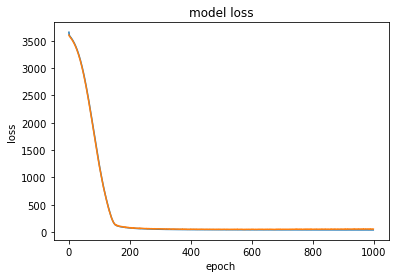

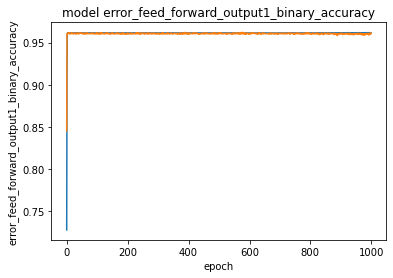

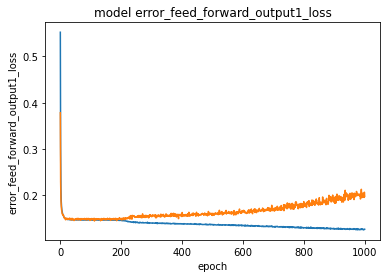

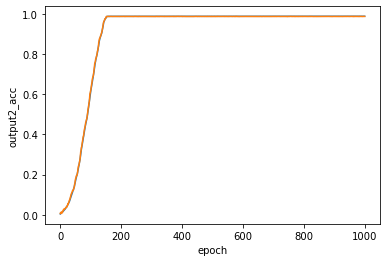

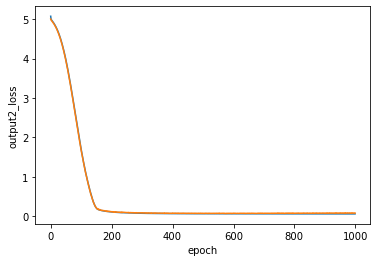

In [41]:
plotTrainingLoss(history)
plotTrainingErrorTypeAcc(history)
plotTrainingErrorTypeLoss(history)
plotTrainingErrorLineAcc(history)
plotTrainingErrorLineLoss(history)